### Test on a crioconite sample
The SSE background reduction allows for detecting peaks covered by Compton events of radioactive sources with higher activities. In this notebook we test the A/E method and the autoencoder+classifier method for unveiling the presence of a peak at ~480 keV (due to a crioconite sample) otherwise covered by the Compton Edge of the 137 - Cs

In [1]:
from begepro.autoencoder.sn_analysis import Comparison, compute_threshold
from begepro.autoencoder.dataloading import DataLoader, Dataset
from begepro.autoencoder.autoencoder_classifier import Autoencoder, Classifier

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

2023-02-10 10:43:01.773861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 10:43:01.881955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 10:43:01.881974: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-10 10:43:02.386967: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Data and models loading

In [2]:
opts = {"loadpath": "/mnt/e/BEGE_data/waveforms_crioconite", # where .bin files are stored
"savepath": "../../dataset/crioconite", # where .npy files will be saved with readfiles() and loaded with load()
"subsampling_factor": 3}
dataloader = DataLoader(opts)

waveforms, currents, energies, amplitudes, pulse_height = dataloader.load()

autoencoder_class = Autoencoder()
classifier_class = Classifier(input_size = 5)
autoencoder_class.load_model("../../models/autoencoder", "../../models/encoder")
classifier_class.load_model("../../models/classifier")

2023-02-10 10:43:03.817350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-02-10 10:43:03.817404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DARTWARS0): /proc/driver/nvidia/version does not exist
2023-02-10 10:43:03.817672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Scaling factors for the encoded datapoints (necessary step before passing to the classifier)
mus = np.array([4.778311 , 4.25894  , 3.7369454, 4.971836 , 3.8563824])
stds = np.array([1.23048101e-03, 6.46553329e-04, 6.02247721e-01, 6.72660279e-01,
        4.74731220e-05])
predictions, _, _ = autoencoder_class.encode(waveforms, mus, stds)

   60/46875 [..............................] - ETA: 39s    

2023-02-10 10:43:04.937483: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 732000000 exceeds 10% of free system memory.


46875/46875 [==============================] - 37s 783us/step


Getting the NN prediction scores 

In [4]:
scores = classifier_class.classifier.predict(predictions)[:,0]

46875/46875 [==============================] - 37s 787us/step


Computing A/E ratios

In [5]:
avse = amplitudes/pulse_height

Example: selecting events with scores > 0.3

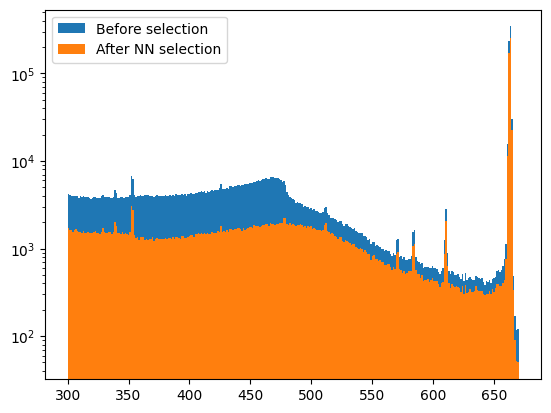

In [6]:
predictions_nn = scores > 0.3
avse_threshold = compute_threshold(avse, predictions_nn.sum(), "avse", stress_limit = 100000)
nbins = 301
plt.hist(energies, range = [300, 670], bins = nbins)[-1]
plt.hist(energies[predictions_nn], range = [300, 670], bins = nbins)[-1]
plt.legend(["Before selection", "After NN selection"])
plt.yscale("log")

Selecting the same number of events in the overall spectrum with the A/E method (i.e. A/E < 0.01828)

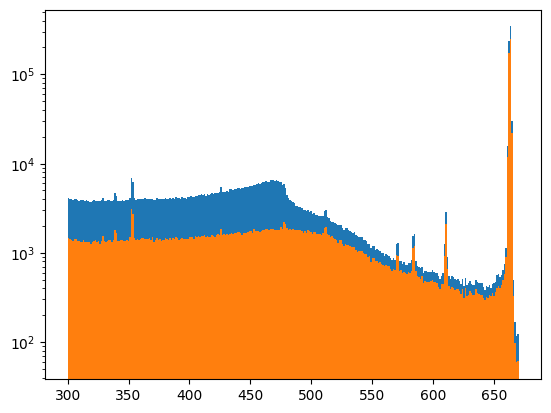

In [7]:
plt.hist(energies, range = [300, 670], bins = nbins)[-1]
plt.hist(energies[avse < avse_threshold], range = [300, 670], bins = nbins)[-1]
plt.yscale("log")

Getting the S/B ratio at different selection strengths

In [8]:
comparison = Comparison(energies, avse, scores)
M_ELECTRON = 511
cs = np.linspace(0.0, 0.695, 100)
peaks = [478]
sb_nn, std_sb_nn, sb_avse, std_sb_avse = comparison.compare([478], cs, benchmark = "nn", width = 10, nbins = 19)

Estimating S/B for peak at 478 keV


/home/rmoretti/BEGe/BEGepro/begepro/autoencoder/sn_analysis.py:82: UserWarning: No peaks found.
  warnings.warn("No peaks found.")
/home/rmoretti/BEGe/BEGepro/begepro/autoencoder/sn_analysis.py:110: UserWarning: The fit did not converge.
  warnings.warn("The fit did not converge.")


### Results
Without enough selection (score threshold $\lesssim 0.2$) The fit fails in detecting the peak. Overall, the A/E method seems to perform better, despite the large error bars.

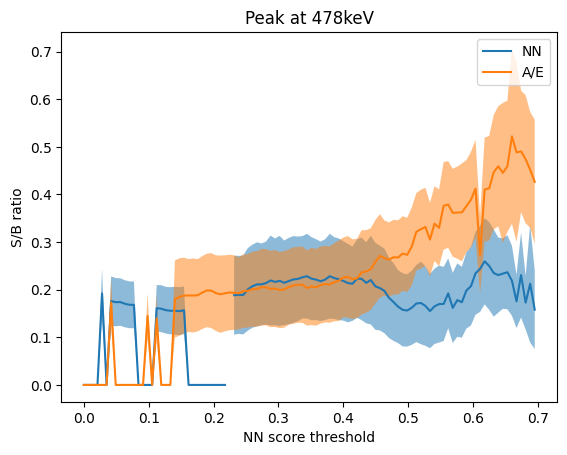

In [9]:
for n in range(len(peaks)):
    plt.plot(cs, sb_nn[:,n])
    plt.fill_between(cs, sb_nn[:,n] + std_sb_nn[:,n], sb_nn[:,n] - std_sb_nn[:,n],label='_nolegend_', alpha = 0.5)
    plt.plot(cs, sb_avse[:,n])
    plt.fill_between(cs, sb_avse[:,n] + std_sb_avse[:,n], sb_avse[:,n] - std_sb_avse[:,n],label='_nolegend_', alpha = 0.5)
    plt.xlabel("NN score threshold")
    plt.ylabel("S/B ratio")
    plt.title(f"Peak at {peaks[n]}keV")
    plt.legend(["NN", "A/E"])
    plt.savefig(f"../../results/z_peak_at_{peaks[n]}_122_sampling.svg")
    # plt.clf()